In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

In [4]:
save_images = True

In [5]:
outfolder = '211118_nanostring'

In [6]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [7]:
pr = properties.genbank_gene(taxon_id=10090)[['gene_ncbi', 'Genbank__gene: SumACGT']].rename(columns={
    'Genbank__gene: SumACGT': 'length'
})
pr.loc[:, 'log_length'] = np.log10(pr['length'])

In [8]:
p = '/Users/tstoeger/Dropbox/aging_map_paper/nanostring/result/Budinger-Stoeger_Nanostring_Results.xlsx'

In [9]:
df = pd.read_excel(p)

In [10]:
df = df[['Probe Name', '24 vs. 4']].drop_duplicates().rename(
    columns={'Probe Name': 'symbol', '24 vs. 4': 'change'}
)

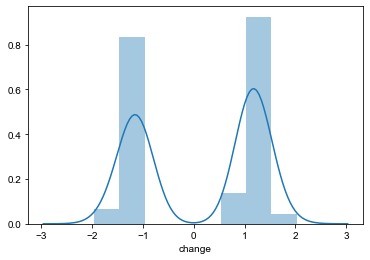

In [11]:
sns.distplot(df['change'])

In [12]:
from access_biology_data import gene_mapper

In [13]:
df['symbol'].value_counts()

Mapk8     1
Ndufs8    1
Efna4     1
Slc3a2    1
Cybb      1
         ..
Cacng7    1
Rb1cc1    1
Grin1     1
Atf4      1
Idh1      1
Name: symbol, Length: 768, dtype: int64

In [14]:
df

,symbol,change
0,A2m,1.01
1,Aadat,-1.48
2,Aanat,1.08
3,Abl1,-1.13
4,Acaa2,1.18
...,...,...
763,Tbc1d10b,-1.18
764,Tbp,1.01
765,Tlk2,-1.02
766,Ubb,1.19


In [15]:
df = gene_mapper.symbol_2_gene_ncbi(
    df.rename(columns={'symbol': 'symbol_ambiguous'}), 10090, how='median').reset_index()

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
df

,gene_ncbi,change
0,11298,1.08
1,11350,-1.13
2,11363,1.03
3,11430,-1.14
4,11484,1.09
...,...,...
758,435653,1.28
759,625249,1.33
760,666907,-1.22
761,100043314,-1.10


In [17]:
# sys.path.append('./../../../prepare_gustav/src')

# from gustav import mapper

# df = mapper.symbol_2_gene_ncbi(df, 10090)

In [18]:
m = pd.merge(df, pr)

In [19]:
spearmanr(m['log_length'], m['change'])

SpearmanrResult(correlation=-0.35623477272500964, pvalue=3.0183970955405415e-24)

In [20]:
m['up'] = m['change'] >0 

In [21]:
m

,gene_ncbi,change,length,log_length,up
0,11298,1.08,5960,3.775246,True
1,11350,-1.13,118740,5.074597,False
2,11363,1.03,32471,4.511496,True
3,11430,-1.14,27163,4.433978,False
4,11484,1.09,21881,4.340067,True
...,...,...,...,...,...
758,435653,1.28,7009,3.845656,True
759,625249,1.33,9274,3.967267,True
760,666907,-1.22,17428,4.241248,False
761,100043314,-1.10,15556,4.191898,False


In [22]:
from scipy.stats import mannwhitneyu

In [23]:
mannwhitneyu(
    m[m['up']==False]['log_length'],
    m[m['up']==True]['log_length'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=101174.5, pvalue=6.378817714180644e-22)

In [24]:
m['up'].value_counts()

True     420
False    343
Name: up, dtype: int64

In [25]:
m

,gene_ncbi,change,length,log_length,up
0,11298,1.08,5960,3.775246,True
1,11350,-1.13,118740,5.074597,False
2,11363,1.03,32471,4.511496,True
3,11430,-1.14,27163,4.433978,False
4,11484,1.09,21881,4.340067,True
...,...,...,...,...,...
758,435653,1.28,7009,3.845656,True
759,625249,1.33,9274,3.967267,True
760,666907,-1.22,17428,4.241248,False
761,100043314,-1.10,15556,4.191898,False


In [26]:
m['up'].value_counts()

True     420
False    343
Name: up, dtype: int64

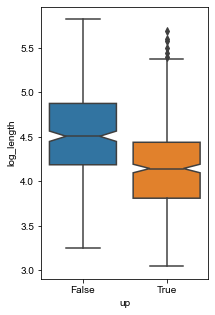

In [27]:
plt.figure(figsize=(3, 5))
sns.boxplot(x='up', y='log_length', data=m, notch=True)

if save_images:
    export.export_image(
        f'{outfolder}/length_up_down.pdf')



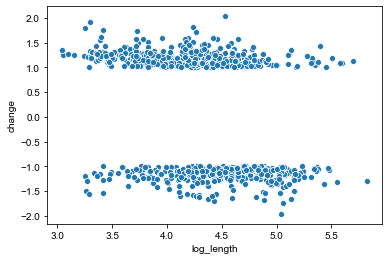

In [28]:
sns.scatterplot(m['log_length'], m['change'])